<a href="https://colab.research.google.com/github/R4HUL-ROY/Multimodal_feature_extraction/blob/main/MobileNetV2_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pathlib
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
# import seaborn as sns
# sns.set_style('darkgrid')
# from IPython.core.display import display, HTML

# Get the Image Files

In [2]:
data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg/')

print(data_root)
for item in data_root.iterdir():
  print(item)

/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/ADVE
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Note
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/Letter


In [3]:
def get_file_paths_and_labels(data_root):
     img_paths = [str(path) for path in data_root.glob('*/*.jpg')]
     labels = [p.split("/")[-2] for p in img_paths]
     return img_paths, labels

img_paths, labels = get_file_paths_and_labels(data_root)
print(img_paths)
print(labels)
print(len(img_paths))
print(len(labels))

['/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0000136188.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0000435350.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0030049569.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0000556056.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03496270.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0030048095.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03722789.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03567810.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/0030048989.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04412344.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04233037_04233039.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04102204.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/04106546.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/1002760819.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/1002761179.jpg', '/content/drive/MyDrive/Tobacco3482-jpg/ADVE/1002325458.jpg', '/content/dr

# Create Dataframe

In [4]:
df = pd.DataFrame(list(zip(img_paths, labels)),
               columns =['image_path', 'data_label'])
df.head()

,image_path,data_label
0,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
1,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
2,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
3,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/00...,ADVE
4,/content/drive/MyDrive/Tobacco3482-jpg/ADVE/03...,ADVE


In [5]:
balance=df['data_label'].value_counts()
print (balance)

Memo          620
Email         599
Letter        567
Form          431
Report        265
Scientific    261
ADVE          230
Note          201
News          188
Resume        120
Name: data_label, dtype: int64


# Split dataframe into train, test and validation dataframe

In [6]:
train_df, dummy_df=train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
test_df, valid_df= train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)
print (f"train size: {len(train_df)} test size: {len(test_df)}  valid size: {len(valid_df)}")
length=len(test_df)

train size: 2785 test size: 348  valid size: 349


# Keras ImageDataGenarator Preprocessing

In [7]:
batch_size=32
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1

trgen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=scalar, 
    shear_range=0.1,
)

train_gen=trgen.flow_from_dataframe(train_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=True)

tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=False)

# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  

test_steps=int(length/test_batch_size)

test_gen=tvgen.flow_from_dataframe(test_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=test_batch_size, shuffle=False)

test_labels=test_gen.labels

Found 2785 validated image filenames belonging to 10 classes.
Found 349 validated image filenames belonging to 10 classes.
Found 348 validated image filenames belonging to 10 classes.


# Created Tranfer Learning model with MobileNetv2

In [8]:
img_shape=(224,224,3)
class_count = len(set(df['data_label']))
neurons=512
dropout=.2
lr= 0.001
freeze=True
seed_value = 42


base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet') 
if freeze:
    base_model.trainable=False

x=base_model.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99 , epsilon=0.001 )(x)

x =tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform())(x)

x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)

x=tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform())(x)

x=tf.keras.layers.Dropout(rate=dropout)(x)

output=tf.keras.layers.Dense(class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform())(x)

model=Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

9420800/9406464 [==============================] - 0s 0us/step


# Model Summary

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Train the Model

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5", verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

history=model.fit(x=train_gen,  epochs=20, verbose=2, validation_data=valid_gen, callbacks=[checkpoint],
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/20

Epoch 1: val_loss improved from inf to 15.14005, saving model to /model-001-0.553321-0.535817.h5
88/88 - 898s - loss: 18.6663 - accuracy: 0.5533 - val_loss: 15.1400 - val_accuracy: 0.5358 - 898s/epoch - 10s/step
Epoch 2/20

Epoch 2: val_loss improved from 15.14005 to 9.97017, saving model to /model-002-0.690126-0.667622.h5
88/88 - 123s - loss: 12.0913 - accuracy: 0.6901 - val_loss: 9.9702 - val_accuracy: 0.6676 - 123s/epoch - 1s/step
Epoch 3/20

Epoch 3: val_loss improved from 9.97017 to 6.84340, saving model to /model-003-0.746140-0.693410.h5
88/88 - 120s - loss: 8.1488 - accuracy: 0.7461 - val_loss: 6.8434 - val_accuracy: 0.6934 - 120s/epoch - 1s/step
Epoch 4/20

Epoch 4: val_loss improved from 6.84340 to 4.89330, saving model to /model-004-0.789946-0.704871.h5
88/88 - 115s - loss: 5.6149 - accuracy: 0.7899 - val_loss: 4.8933 - val_accuracy: 0.7049 - 115s/epoch - 1s/step
Epoch 5/20

Epoch 5: val_loss improved from 4.89330 to 3.66510, saving model to /model-005-0.812208-0.

# Fine Tune the model

In [11]:
epochs = 20
base_model.trainable=True
fine_tune_epochs= 10
total_epochs=epochs + fine_tune_epochs
history=model.fit(x=train_gen,  epochs=total_epochs, verbose=2, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=epochs)

Epoch 21/30
88/88 - 114s - loss: 0.7880 - accuracy: 0.9688 - val_loss: 1.4226 - val_accuracy: 0.7307 - 114s/epoch - 1s/step
Epoch 22/30
88/88 - 114s - loss: 0.7736 - accuracy: 0.9684 - val_loss: 1.3704 - val_accuracy: 0.7421 - 114s/epoch - 1s/step
Epoch 23/30
88/88 - 114s - loss: 0.7467 - accuracy: 0.9706 - val_loss: 1.3659 - val_accuracy: 0.7507 - 114s/epoch - 1s/step
Epoch 24/30
88/88 - 114s - loss: 0.7311 - accuracy: 0.9698 - val_loss: 1.3934 - val_accuracy: 0.7163 - 114s/epoch - 1s/step
Epoch 25/30
88/88 - 113s - loss: 0.7118 - accuracy: 0.9738 - val_loss: 1.3924 - val_accuracy: 0.7192 - 113s/epoch - 1s/step
Epoch 26/30
88/88 - 113s - loss: 0.7129 - accuracy: 0.9655 - val_loss: 1.4040 - val_accuracy: 0.7163 - 113s/epoch - 1s/step
Epoch 27/30
88/88 - 113s - loss: 0.6882 - accuracy: 0.9713 - val_loss: 1.3559 - val_accuracy: 0.7249 - 113s/epoch - 1s/step
Epoch 28/30
88/88 - 113s - loss: 0.6531 - accuracy: 0.9788 - val_loss: 1.3499 - val_accuracy: 0.7335 - 113s/epoch - 1s/step
Epoch 29

# Evaluate

In [12]:
model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=True)

12/12 [==============================] - 89s 8s/step - loss: 1.3625 - accuracy: 0.7328


{'accuracy': 0.732758641242981, 'loss': 1.3625468015670776}

# Plot Train and Validation accuracy and Loss

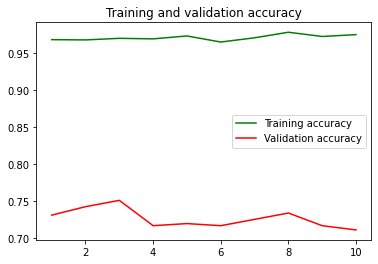

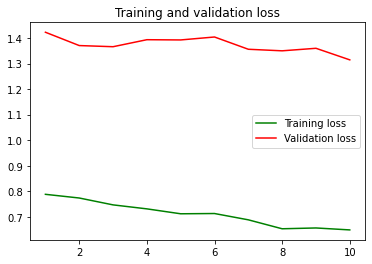

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()